# Trash Detection with Pytorch Mask R-CNN

In this notebook, we evaluate the performance of [Mask R-CNN](https://arxiv.org/abs/1703.06870) on the [Trash Annotations in Context (TACO) dataset](http://tacodataset.org/). TACO consists of 1500 photos of litter taken in diverse environments, annotated according to the [COCO](http://cocodataset.org/#home) format.

We look at the performance of the [Pytorch implementation of Mask R-CNN](https://github.com/pytorch/vision/blob/master/torchvision/models/detection/mask_rcnn.py) pre-trained only on the COCO dataset, and finetuned on the TACO dataset. Special attention is given to dealing with the class imbalances in the TACO dataset.

Many parts of this notebook were heavily inspired by the [TorchVision 0.3 Object Detection finetuning tutorial](https://colab.research.google.com/github/pytorch/vision/blob/temp-tutorial/tutorials/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=DfPPQ6ztJhv4).

First, we install `pycocotools`. This library is used for computing the [COCO evaluation metrics](http://cocodataset.org/#detection-eval).

In [1]:
!pip install cython
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-qj74a_er
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-qj74a_er
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266983 sha256=d7ba593099c0ff55f02ace414652ba746010c34a54c43e6656de2124698d890b
  Stored in directory: /tmp/pip-ephem-wheel-cache-5xg00kbj/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.1
    Uninstalling pycocotools-2.0.1:
      Successfully uninstalled pycocotools-2.0.1


We also define some helper methods to plot the output of our models.

In [2]:
from typing import Tuple, List
import colorsys
def hsv2rgb(h: float, s: float, v: float) -> Tuple[int, int, int]:
  """
  Source: https://stackoverflow.com/a/24852375
  Convert a color in HSV to RGB.

  :param h: the hue
  :param s: the saturation
  :param v: the value
  :returns: a tuple representing the color in RGB
  """
  return tuple(round(i * 255) for i in colorsys.hsv_to_rgb(h,s,v))

def generate_palette(N: int, bright: bool = True) -> List[int]:
  """
  Generate visually distinct colors plus black.

  :param N: the number of colors to generate
  :param bright: whether or not the colors should be bright
  :returns: a list where each consecutive three numbers represent one RGB color
  """

  brightness = 1.0 if bright else 0.7
  hsv = [(i / (N - 1), 1, brightness) for i in range(N - 1)]
  colors = list(map(lambda c: hsv2rgb(*c), hsv))
  
  colors = list(sum(colors, ()))
  b = [0,0,0] # add black as the background color
  b.extend(colors)
  return b

# We use the same palette throughout so define it once.
PALETTE = generate_palette(29)


In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# The class names in order. The index of each class corresponds to its label.
# The class names never change, so define them as a constant.
CLASSES = ["Background", "Aluminium foil", "Battery","Blister pack","Bottle","Bottle cap","Broken glass","Can","Carton","Cup","Food waste","Glass jar","Lid","Other plastic","Paper","Paper bag","Plastic bag & wrapper","Plastic container","Plastic gloves","Plastic utensils","Pop tab","Rope & strings","Scrap metal","Shoe","Squeezable tube","Straw","Styrofoam piece","Unlabeled litter","Cigarette"]

def plot_image_mask(image: Image.Image, mask: Image.Image, include_undefined: bool = False):
  """
  Plot an image and its segmentation mask side by side.

  :param image: the image
  :param mask: the segmentation mask
  :param include_undefined: whether or not to plot regions with an undefined class
  """
  
  mask.putpalette(PALETTE)

  fig, axarr = plt.subplots(1, 2, figsize = (20,30))

  axarr[0].imshow(image)
  axarr[1].imshow(mask)

  patches = [mpatches.Patch(color=(PALETTE[3 * i]/255, PALETTE[3 * i + 1]/255, PALETTE[3 * i + 2]/255), label=CLASSES[i]) for i in range(len(CLASSES))]

  if include_undefined:
    patches.append(mpatches.Patch(color=(1,1,1), label="Undefined"))

  axarr[1].legend(handles=patches, bbox_to_anchor=(1.05, 1.0), loc="upper left")

def plot_image_mask_prediction(image: Image.Image, mask: Image.Image, predicted_mask: Image, include_undefined=False):
  """
  Plot an image and its segmentation mask side by side.

  :param image: the image
  :param mask: the original segmentation mask
  :param predicted_mask: the predicted segmentation mask
  :param include_undefined: whether or not to plot regions with an undefined class
  """

 
  mask.putpalette(PALETTE)
  predicted_mask.putpalette(PALETTE)

  fig, axarr = plt.subplots(1, 3, figsize = (20,30))

  axarr[0].imshow(image)
  axarr[1].imshow(mask)
  axarr[2].imshow(predicted_mask)

  patches = [mpatches.Patch(color=(PALETTE[3 * i]/255, PALETTE[3 * i + 1]/255, PALETTE[3 * i + 2]/255), label=CLASSES[i]) for i in range(len(CLASSES))]

  if include_undefined:
    patches.append(mpatches.Patch(color=(1,1,1), label="Undefined"))


  axarr[2].legend(handles=patches, bbox_to_anchor=(1.05, 1.0), loc="upper left")


## Dataset

### Pre-processing
We pre-processed the TACO dataset to make it suitable for use with various Pytorch models. During pre-processing, we:

- Reduced the image resolution to achieve feasible training times.
- Generated segmentation masks. 
- Set areas in the segmentation masks with overlapping classes to 255. We use this label to signify an 'Undefined' class, and ignore it during training.

The pre-processed dataset is hosted on [Kaggle](https://www.kaggle.com/).

Let us download the images and segmentation masks.

In [4]:
from pathlib import Path
import os

IMAGES = "taco-dataset-resized-640"
MASKS = "taco-dataset-resized-640-masks"


def download_data(replace=False, dataset_name = IMAGES, dataset_destination = IMAGES):
  if replace or not Path(f"/content/{dataset_destination}").exists():
    print(f"Downloading and unpacking {dataset_name}...")
    os.environ['KAGGLE_USERNAME'] = "verahoveling"
    os.environ['KAGGLE_KEY'] = "1553f496337ebdcc5b2b6710de4fb748" 
    !kaggle datasets download "verahoveling/"$dataset_name
    !unzip -q "/content/"$dataset_name".zip" -d $dataset_destination


def download_masks(replace=False, dataset_name = MASKS, dataset_destination = MASKS):
  if replace or not Path(f"/content/{dataset_destination}").exists():
    print(f"Downloading and unpacking {dataset_name}...")
    os.environ['KAGGLE_USERNAME'] = "sranjha"
    os.environ['KAGGLE_KEY'] = "57d3733a9bceac9771f0295b9f791080" 
    !kaggle datasets download "sranjha/"$dataset_name
    !unzip -q "/content/"$dataset_name".zip" -d $dataset_destination


download_data()
download_masks()

 97% 122M/126M [00:04<00:00, 40.7MB/s]
100% 126M/126M [00:04<00:00, 32.3MB/s]
  0% 0.00/1.80M [00:00<?, ?B/s]
100% 1.80M/1.80M [00:00<00:00, 59.3MB/s]


The data is structured as follows
```
taco-dataset-resized-640/
  content/
    batch_1/
      000000.jpg
      ...
    batch_2/
      000000.jpg
      ...
    ...
    annotations.json
    
taco-dataset-resized-640-masks/
  masks_pt/
    0.pt
    1.pt
    ...
```

Note the presence of `annotations.json`. This file links the different images to the correct mask.

### Datasets for Mask R-CNN
The [Pytorch implementation of Mask R-CNN](https://github.com/pytorch/vision/blob/master/torchvision/models/detection/mask_rcnn.py) puts some extra requirements on the format of the data. These are:

*   Bounding boxes can not be 0 in any dimension.
*   Bounding boxes can not fall outside of the image.
*   Bounding boxes can not be "too small".
*   Class labels have to fall within the valid range of labels.
*   Each image must be accompanied by at least one mask.

Normally, these conditions are checked when loading an image/target pair. At that time, any bounding boxes that do not meet the requirements can be discarded. However, this can result in image/target pairs without any bounding boxes/masks. Therefore, we determine the valid images beforehand, and only load those image/target pairs meeting the requirements.



In [5]:
import json
import torch
from torchvision import transforms as tf

IMAGES_ROOT = f"/content/{IMAGES}/content"
MASKS_ROOT = f"/content/{MASKS}/masks_pt"
ANN_FILE = f"{IMAGES_ROOT}/annotations.json"

def find_valid_taco_ids(img_root: str = IMAGES_ROOT, mask_root: str = MASKS_ROOT, annotation_file: str = ANN_FILE) -> List[int]:
  valid_taco_ids = []

  annotations = json.load(Path(annotation_file).open("r"))
  images = annotations['images']

  for image in images:
    # Load the mask.
    image_path = Path(img_root).joinpath(image['file_name']) 
    image_id = image['id']

    img = Image.open(image_path)
    img = tf.ToTensor()(img)

    # Check if the values in the image are in the range [0,1].
    if img.max() > 1.0 or img.min() < 0.0: 
      continue

    mask_path = Path(mask_root).joinpath(f"{image_id}.pt")
    mask = torch.load(mask_path)
    
    # Extract the class lables.
    obj_ids = torch.unique(mask)

    # The first label (0) is reserved for the background, so we remove it.
    obj_ids = obj_ids[1:]                       
    
    # Label 255 is not a valid class so we remove it.
    obj_ids = obj_ids[obj_ids != 255]           
    
    # Create masks from the valid labels.
    masks = mask == obj_ids[:, None, None]
    
    # Generate bounding boxes.
    boxes = []
    for i in range(len(obj_ids)):
      pos = torch.where(masks[i])
      xmin = torch.min(pos[1])
      xmax = torch.max(pos[1])
      ymin = torch.min(pos[0])
      ymax = torch.max(pos[0])

      boxes.append([xmin, ymin, xmax, ymax])

    boxes = torch.as_tensor(boxes, dtype=torch.float32)

    # If at this point there are 0 bounding boxes, go to the next image. 
    # We check for the number of bounding boxes here because the next line throws an error when then number of bounding boxes is 0.
    if len(boxes) == 0:
      continue

    # Filter out all boxes that are 0 length in one dimension and/or have an area of less than 10 pixels.
    keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
    boxes = boxes[keep]

    # If there are bounding boxes left, this is a valid image.
    if len(boxes) > 0:
      valid_taco_ids.append(image_id)
    
  return valid_taco_ids



In [6]:
valid_ids = find_valid_taco_ids()
print(f"Using {len(valid_ids)}/1500 images.")

Using 1286/1500 images.


### Custom dataset implementation

Pytorch allows us to easily create a custom dataset which we can then use with all Pytorch's utility functions. The dataset inherits from `torch.utils.data.Dataset` and implements `__len__` and `__getitem__`.

During training, Pytorch's Mask R-CNN expects:
*   image: a torch tensor of size (H, W)
*    target: a `dict` containing the following fields:
    * `boxes` (`FloatTensor[M, 4]`): the coordinates of the `M` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[M]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[M]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[M]`): instances with `iscrowd=True` will be ignored during evaluation. `iscrowd=False` for each image in the TACO dataset, but we include it because the model expects it
    * `masks` (`UInt8Tensor[M, H, W]`): The segmentation masks for each one of the objects

In each of the elements above, `M` represents the number of valid masks/bounding boxes in an image.

With the list of valid ids, we can make sure that only valid image/target pairs are loaded. Even so, at load time we need to make sure that
*   Images and masks have the same orientation
*   Image values are in the range `[0,1]`
*   Bounding boxes are clamped to the size of the image
*   Invalid bounding boxes are not used

In [7]:
import numpy as np
from typing import Dict

class TacoDataset(torch.utils.data.Dataset):
  def __init__(self, valid_taco_ids: List, img_root: str = IMAGES_ROOT, mask_root: str = MASKS_ROOT, annotation_file: str = ANN_FILE, transforms = None):
    """
    Initalize a TACO dataset.

    :param img_root: path to the image directory
    :param mask_root: path to the mask directory
    :param annotation_file: path to the file linking images and masks
    :param valid_taco_ids: ids of the TACO images meeting Mask R-CNNs requirements
    :param transforms: transforms to apply to an image at loading time
    """
    self.img_root = img_root
    self.mask_root = mask_root
    self.transforms = transforms

    # dictionaries pointing an image id to the path to the image and its mask
    self.imgs = {}
    self.masks =  {}

    self.valid_taco_ids = valid_taco_ids


    # Add all valid images and their accompanying masks.
    annotations = json.load(Path(annotation_file).open("r"))
    images = annotations['images']
    for image in images:
      image_path = Path(img_root).joinpath(image['file_name']) 
      image_id = image['id']
    
      mask_path = Path(mask_root).joinpath(f"{image_id}.pt")
      self.imgs[image_id] = image_path
      self.masks[image_id] = mask_path

    
  def load_image(self, idx: int) -> Image:
    """
    Load the specified image and return as a PIL image.
    
    :param idx: the image id
    :returns: a PIL image representation of the image
    """
    idx = self.valid_taco_ids[idx]

    image = Image.open(Path(self.img_root).joinpath(self.imgs[idx]))
    img_shape = np.shape(image)      


    # load metadata
    exif = image._getexif()
    if exif:
      exif = dict(exif.items())
      # Rotate portrait images if necessary (274 is the orientation tag code)
      if 274 in exif:
        if exif[274] == 3:
          image = image.rotate(180, expand=True)
        if exif[274] == 6:
          image = image.rotate(270, expand=True)
        if exif[274] == 8:
          image = image.rotate(90, expand=True)

    # If has an alpha channel, remove it for consistency
    if img_shape[-1] == 4:
      image = image[..., :3]

    return image

  def load_mask(self, idx: int) -> torch.tensor:
    """
    Load the specified mask and return as a pytorch tensor.

    :param idx: the id of the corresponding image
    :returns: the segmentation mask as a Pytorch tensor
    """

    idx = self.valid_taco_ids[idx]
    mask = torch.load(Path(self.mask_root).joinpath(self.masks[idx])) 
    return mask
      
  def load_img_and_mask(self, idx: int) -> Tuple[Image.Image, Image.Image]:
    """
    Load an image/mask pair.

    :param idx: the image index
    :returns: a tuple of two PIL images, the image and the mask
    """
    image = self.load_image(idx)
    mask = tf.ToPILImage()(self.load_mask(idx))
    return image, mask


  def __len__(self):
    return len(self.valid_taco_ids)
  
  def __getitem__(self, idx: int) -> Tuple[torch.tensor, Dict[str, torch.tensor]]:
    """
    Load an image and target pair. The target is computed based on the corresponding segmentation mask.

    :param idx: the index of the image to be loaded
    :return: an image/target pair
    """   

    image = tf.ToTensor()(self.load_image(idx))
    mask = self.load_mask(idx)

    if self.transforms is not None:      
      image, mask = self.transforms(image, mask)
      
    _, im_t_h, im_t_w = image.shape  
    m_t_h, m_t_w = mask.shape
    if not (im_t_h == m_t_h and im_t_w == m_t_w):
      print(f"Ratios of image {idx} do not match.")
    
    obj_ids = torch.unique(mask)      # extract class labels
    obj_ids = obj_ids[1:]             # first label (0) reserved for background                       
    obj_ids = obj_ids[obj_ids != 255] # 255 is not a valid class label           
    
    masks = mask == obj_ids[:, None, None]
  
    num_objs = len(obj_ids)
    boxes = []
    labels = []
    for i in range(num_objs):
      pos = torch.where(masks[i])
      xmin = torch.min(pos[1])
      xmax = torch.max(pos[1])
      ymin = torch.min(pos[0])
      ymax = torch.max(pos[0])

      boxes.append([xmin, ymin, xmax, ymax])
      labels.append(obj_ids[i])

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    boxes[:, 0::2].clamp_(min=0, max=im_t_w)
    boxes[:, 1::2].clamp_(min=0, max=im_t_h)
     
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.bool) 
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) 

    keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])

    boxes = boxes[keep]
    labels = labels[keep]
    masks = masks[keep]
    area = area[keep]
    iscrowd = iscrowd[keep]
    
    # create target
    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    target['masks'] = masks
    target['image_id'] = torch.tensor([idx])
    target['area'] = area
    target['iscrowd'] = iscrowd
    target['taco_id'] = torch.tensor(self.valid_taco_ids[idx])
 
    return image, target

  

Let's look at a random image.

In [8]:
ds = TacoDataset(valid_ids)

Image id: 400.


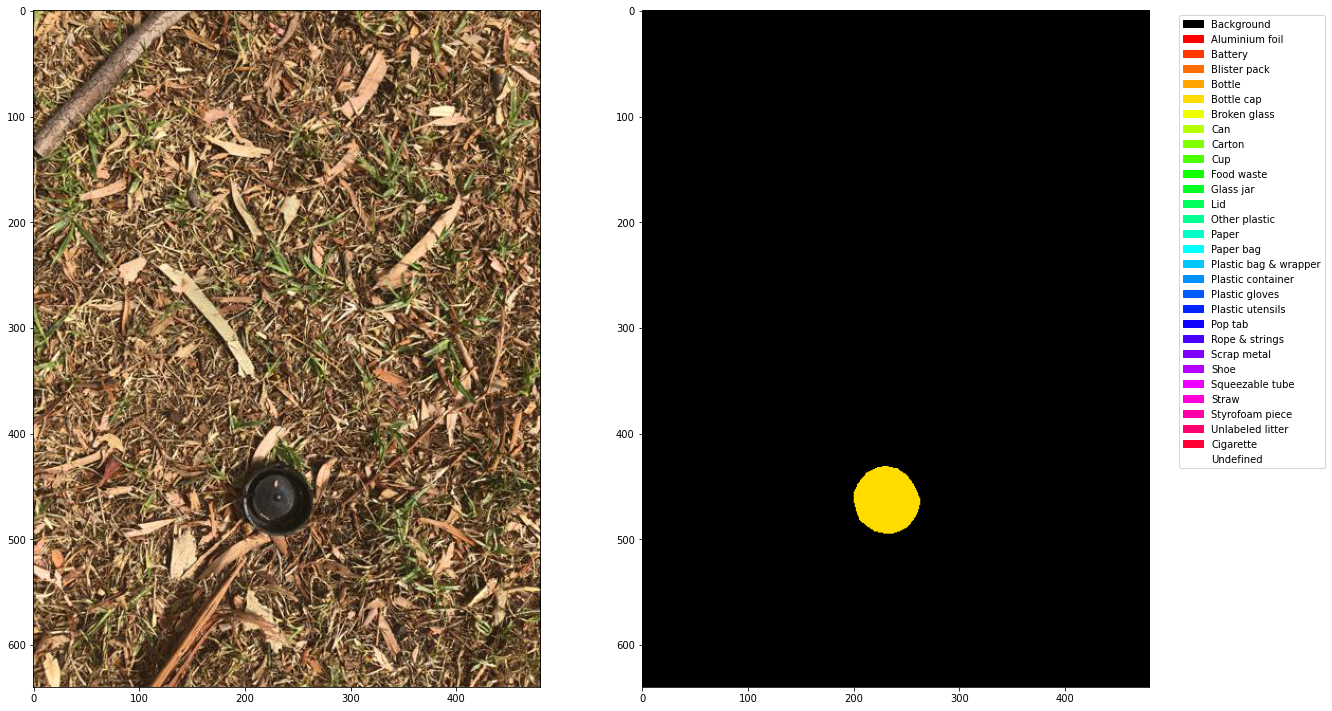

In [9]:
index = np.random.randint(len(ds))
# index = 684 # uncomment this line to see a specific image
print(f"Image id: {index}.")
image, mask = ds.load_img_and_mask(index)
plot_image_mask(image, mask, include_undefined=True)


The image has a corresponding segmentation mask. Each color corresponds to a different class.

## Data Distribution

Whenever you are training a model for any sort of segmentation task, you want to be sure that you have enough data for each class. Otherwise, the model will not be able to learn a representation of the objects it needs to recognize.

In this light, let's look at how our data is distributed.

In [10]:
import pandas as pd 
import seaborn as sns
sns.set()

ds = TacoDataset(valid_ids)
df = pd.DataFrame(data = [d[1] for d in ds])

# count the number of classes per image
df['num_classes'] = df.apply(lambda row: len(row['labels']), axis=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


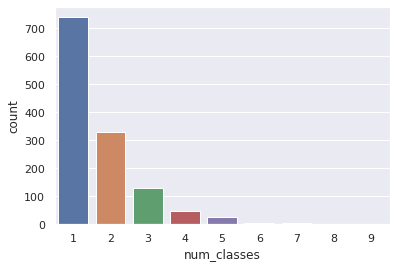

In [11]:
plt.figure()
sns.countplot(data=df,x='num_classes')
plt.show()

Most of our images have only one class, but some of them have up to nine different objects in them! The fact that our images can contain multiple classes means we cannot use weighted sampling to combat potential class imbalances. For a more in-depth discussion of this issue, click [here](https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264/14).

Now, let's see how our classes are distributed.

In [12]:
labs = []
for l in df.labels:
  labs.extend(l.tolist())
df_labels = pd.DataFrame(data=labs, columns=['class_id'])

df_labels['class_name'] = df_labels.apply(lambda row: CLASSES[int(row['class_id'])], axis=1)

In [13]:
df_labels.class_name.value_counts()

Plastic bag & wrapper    432
Bottle                   276
Unlabeled litter         179
Can                      165
Cup                      150
Carton                   150
Bottle cap               144
Other plastic            128
Paper                     92
Cigarette                 84
Plastic container         62
Lid                       60
Styrofoam piece           58
Straw                     52
Aluminium foil            34
Plastic utensils          24
Paper bag                 22
Rope & strings            20
Pop tab                   14
Broken glass               9
Scrap metal                7
Blister pack               6
Squeezable tube            5
Shoe                       5
Food waste                 4
Plastic gloves             4
Glass jar                  4
Battery                    2
Name: class_name, dtype: int64

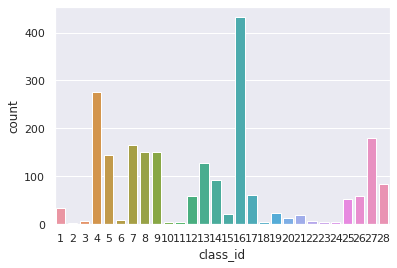

In [14]:
plt.figure()
sns.countplot(data=df_labels,x='class_id')
plt.show()

As we can see, the dataset is rather imbalanced. There are 432 images of a "Plastic bag & wrapper", but only 2 of a "Battery". It will most likely be difficult for our model to learn representations of batteries, and easier to learn what a plastic bag looks like.

## Defining the model

In this notebook, we use [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is in turn is built on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Mask R-CNN also predicts segmentation masks for each instance.

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)

With any model, you can choose to train it from scratch, or fine-tune a pre-trained model. Since our dataset is rather small, we would like to use the information a pre-trained model can give us. 

Pytorch allows us to load a version of Mask R-CNN with a ResNet50 backbone that is pre-trained on COCO 2017. 

In [15]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_mask_rcnn_model(num_classes:int = 29, pretrained: bool = True):
    # load an instance segmentation model pre-trained on COCO 2017
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=pretrained)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

## Training the model

The [Torchvision Github](https://github.com/pytorch/vision/tree/v0.6.1/references/detection) contains a number of scripts with utility methods to make training easier. We use `references/detection/utils.py`, `references/detection/coco_eval.py`, and `references/detection/coco_utils.py`. All training is done on a GPU.

In [16]:
DEVICE = torch.device('cuda:0')

In [17]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision

git checkout tags/v0.6.1

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/coco_utils.py ../


Cloning into 'vision'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 8753 (delta 40), reused 47 (delta 26), pack-reused 8659
Receiving objects: 100% (8753/8753), 10.43 MiB | 6.86 MiB/s, done.
Resolving deltas: 100% (6019/6019), done.
Note: checking out 'tags/v0.6.1'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at fe36f06 .circleci: Regenerate configs


We also use a version of `references/detection/engine.py` that returns the training loss of each epoch.

In [18]:
%%shell
git clone https://gist.github.com/ad47ea7c93366ee55cca3b2c2afd3acd.git
cd ad47ea7c93366ee55cca3b2c2afd3acd

cp engine.py ../
# altered version that return losses

Cloning into 'ad47ea7c93366ee55cca3b2c2afd3acd'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3
Unpacking objects: 100% (3/3), done.


Let's define some more helpers for loading data...

In [19]:



def get_samplers(dataset, val_split=0.1, test_split=0.1, shuffle_dataset=True):
  dataset_size = len(dataset)
  indices = list(range(dataset_size))
  val_split = int(np.floor(val_split * dataset_size))
  test_split = int(np.floor(test_split * dataset_size))

  if shuffle_dataset :
      np.random.shuffle(indices)
  train_indices = indices[(test_split+val_split):]
  val_indices = indices[test_split:(test_split+val_split)]
  test_indices = indices[:test_split]

  train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
  val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

  return train_sampler, val_sampler, test_sampler


def get_dataloaders(dataset, batch_size, shuffle_dataset=True, collate_fn=None, test_batch_size=1):
  train_sampler, val_sampler, test_sampler = get_samplers(dataset=dataset, shuffle_dataset=shuffle_dataset)
  
  train_loader = torch.utils.data.DataLoader(dataset, 
                                     batch_size=batch_size, 
                                     drop_last=True, 
                                     sampler=train_sampler,
                                     collate_fn=collate_fn)
  
  val_loader = torch.utils.data.DataLoader(dataset, 
                                     batch_size=test_batch_size, 
                                     drop_last=True, 
                                     sampler=val_sampler,
                                     collate_fn=collate_fn)
  
  test_loader = torch.utils.data.DataLoader(dataset, 
                                     batch_size=test_batch_size, 
                                     drop_last=True, 
                                     sampler=test_sampler,
                                     collate_fn=collate_fn)
  
  return train_loader, val_loader, test_loader


...for gluing different predicted masks back into one image...

In [20]:
def segmentation_from_separate_masks(masks, labels):
  segmask = torch.zeros(masks.shape[-2:], dtype=torch.uint8)

  for i, mask in enumerate(masks):
    th_idx = torch.where(mask.to(DEVICE) == 1, torch.ones(mask.shape).byte().to(DEVICE), torch.zeros(mask.shape).byte().to(DEVICE)).squeeze()
    th_idx.bool()
    segmask[th_idx] = labels[i].byte()
  segmask = tf.ToPILImage()(segmask)
  return segmask


In [21]:
def segmentation_from_prediction(prediction, treshhold = 0.11):
  keepscores = prediction['scores'] >= treshhold
  predicted_masks = prediction['masks'][keepscores]
  predicted_labels = prediction['labels'][keepscores]
  if len(predicted_masks) == 0:
    predicted_masks = prediction['masks'][:5]
    predicted_labels = prediction['labels'][:5]

  predicted_masks = torch.where(predicted_masks > 0.5, torch.ones(predicted_masks.shape).to(DEVICE), torch.zeros(predicted_masks.shape).to(DEVICE))
  return segmentation_from_separate_masks(reversed(predicted_masks), reversed(predicted_labels))
  
 

...and for performing inference on images from a specific class.

In [22]:
def map_classes_to_ids(ds):
  classes_to_ids = {}
  for d in ds:
    id_tensor = d[1]['image_id']
    labels_tensor = d[1]['labels']
    item_id = id_tensor.item()
    labels_list = labels_tensor.tolist()

    for label in labels_list:
      if label in classes_to_ids:
        classes_to_ids[label].append(item_id)
      else:
        classes_to_ids[label] = [item_id]
  return classes_to_ids

def sorted_class_to_id_map(ds):
  return {k: v for k, v in sorted(map_classes_to_ids(ds).items(), key=lambda item: len(item[1]))}

def one_image_per_class(ds):
  idlist = []
  s = sorted_class_to_id_map(ds)

  for sk in s:
    for idi in s[sk]:
      if idi not in idlist:
        idlist.append(idi)
        break
  return idlist


In [23]:
def plot_mask_for_each_class(model, idlist, ds, th):
  for idx in idlist:
    img, mask = ds.load_img_and_mask(idx)
    img_t, _ = ds[idx]
    model.eval()  
    prediction = model([img_t.to(DEVICE)])[0]
    segmask = segmentation_from_prediction(prediction, treshhold=th)
    plot_image_mask_prediction(img, mask, segmask) 

### Transforms for data augmentation
Lastly, we write some transforms that allow us to augment our data at training time, inspired by `references/detection/transforms.py`. It is important to note that in the `TacoDataset`, transformations are applied to the image and mask first. Then, bounding boxes, labels, etc. are calculated from the transformed image/mask.


In [24]:
import torch.nn.functional as nn_func

# https://imgaug.readthedocs.io/en/latest/_modules/imgaug/augmenters/blur.html#GaussianBlur
def _compute_gaussian_blur_ksize(sigma):
    if sigma < 3.0:
        ksize = 3.3 * sigma  # 99% of weight
    elif sigma < 5.0:
        ksize = 2.9 * sigma  # 97% of weight
    else:
        ksize = 2.6 * sigma  # 95% of weight

    # we use 5x5 here as the minimum size as that simplifies
    # comparisons with gaussian_filter() in the tests
    # TODO reduce this to 3x3
    ksize = int(max(ksize, 5))
    ksize = ksize + 1 if ksize % 2 == 0 else ksize
    return ksize  


# adapted from https://github.com/kechan/FastaiPlayground/blob/master/Quick%20Tour%20of%20Data%20Augmentation.ipynb
def _gaussian_kernel(kernel_size, sigma=2., dim=2, channels=3):
    kernel_size = [kernel_size] * dim
    sigma = [sigma] * dim
    kernel = 1
    meshgrids = torch.meshgrid([torch.arange(size, dtype=torch.float32) for size in kernel_size])
    import math 
    for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
        mean = (size - 1) / 2
        kernel *= 1 / (std * math.sqrt(2 * math.pi)) * torch.exp(-((mgrid - mean) / (2 * std)) ** 2)

    # Make sure sum of values in gaussian kernel equals 1.
    kernel = kernel / torch.sum(kernel)

    # Reshape to depthwise convolutional weight
    kernel = kernel.view(1, 1, *kernel.size())
    kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

    return kernel

def _pad_if_smaller(image, mask, size = 400):
  height, width = image.shape[-2:]
  min_size = min(height, width)
  if min_size < size:
    padh = size - height if height < size else 0
    padw = size - width if width < size else 0
    image = nn_func.pad(image, pad=(padw/2, padw/2, padh/2, padh/2), mode='constant', value=255)
    mask = nn_func.pad(mask, pad=(padw/2, padw/2, padh/2, padh/2), mode='constant', value=0)

  return image, mask

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, mask):
        for t in self.transforms:
            image, mask = t(image, mask)
        return image, mask

class RandomHorizontalFlip(object):
    def __init__(self, prob = 0.5):
        self.prob = prob

    def __call__(self, image, mask):
        if np.random.rand() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
  
            mask = mask.flip(-1)
            
        return image, mask

class RandomVerticalFlip(object):
    def __init__(self, prob = 0.5):
        self.prob = prob

    def __call__(self, image, mask):
        if np.random.rand() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
  
            mask = mask.flip(-2)
            
        return image, mask

class RandomCrop(object):
  def __init__(self, size = 400):
    self.size = size
  
  def __call__(self, image, mask):
    """Image: image tensor
        Target: Target DICT"""
    height, width = image.shape[-2:]
    image, mask = _pad_if_smaller(image, mask, size=self.size)
    i, j, h, w = tf.RandomCrop.get_params(image, output_size=(self.size, self.size))
    image = image[:, i:i + h, j:j + w]
    mask = mask[i:i + h, j:j + w]
    return image, mask

class AdditiveGaussianNoise(object):
  def __init__(self, mean=0., std=1.):
    self.std = std
    self.mean = mean

  def __call__(self, image, mask):
    return image + torch.randn(image.shape) * self.std + self.mean, mask
  
# https://github.com/kechan/FastaiPlayground/blob/master/Quick%20Tour%20of%20Data%20Augmentation.ipynb
class GaussianBlur(object):
  def __init__(self, sigma=0.0):
    self.sigma = sigma

  def __call__(self, image, mask):
    kernel_size = _compute_gaussian_blur_ksize(self.sigma)
    kernel = _gaussian_kernel(kernel_size)

    image = image[None,...]
    padding = int((kernel_size - 1) / 2)
    image = nn_func.pad(image, (padding, padding, padding, padding), mode="reflect")
    image = torch.squeeze(nn_func.conv2d(image, kernel, groups=3))

    return image, mask

In [25]:
def get_taco_augmentations():
  return Compose([
                  AdditiveGaussianNoise(std = 0.225),
                  GaussianBlur(),
                  RandomHorizontalFlip(),
                  RandomVerticalFlip(),])


Let's see the data augmentation in action.

Image id: 1274.


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


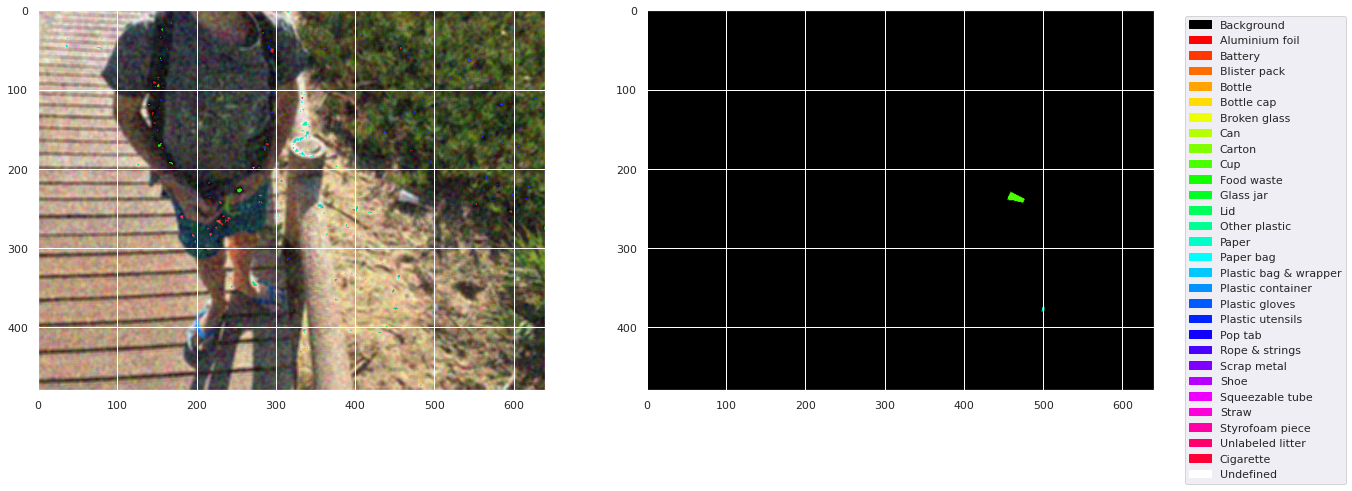

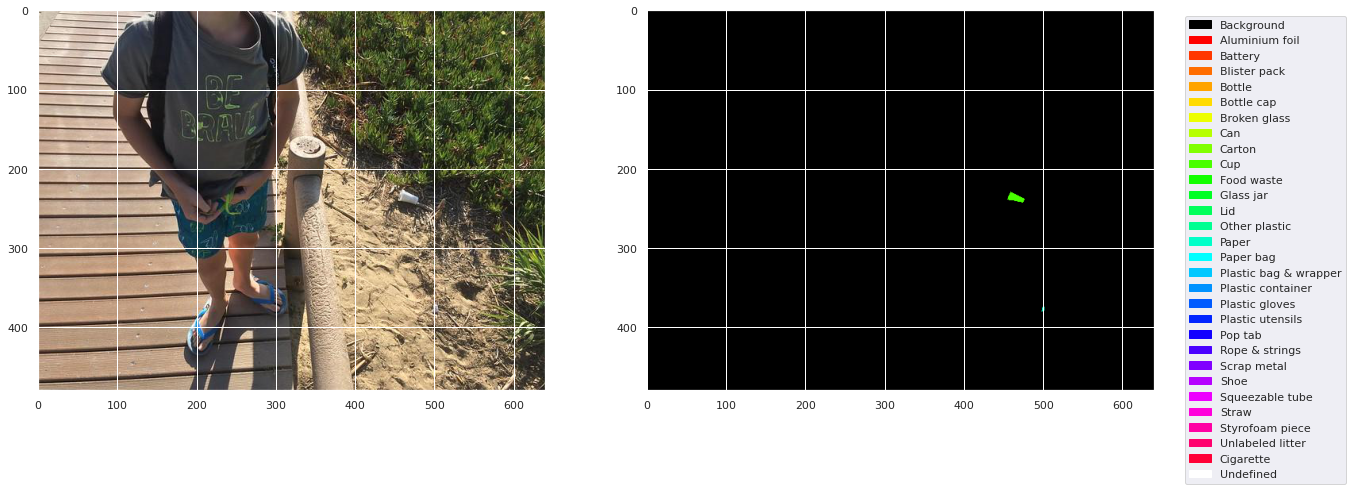

In [26]:
ds_aug  = TacoDataset(valid_ids)
ds_aug  = TacoDataset(valid_ids, transforms=get_taco_augmentations())

index = np.random.randint(len(ds))
# index = 10
print(f"Image id: {index}.")
image, target = ds_aug[index]
image = tf.ToPILImage()(image)
mask = segmentation_from_separate_masks(target['masks'], target['labels'])
plot_image_mask(image, mask, include_undefined=True)

image, mask = ds.load_img_and_mask(index)
plot_image_mask(image, mask, include_undefined=True)



### Training Mask R-CNN

Since we will train the model in a number of different configurations, we define a utility method to do so. We store trained models on Google Drive, so let's mount the drive first.

In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [28]:
import engine
import time
import datetime
def train_mask_rcnn(train_loader, val_loader, lr=0.0001, momentum=0.9, 
          weight_decay=1e-4, step_size=3, gamma=0.1, epochs=30, num_classes=29,
          batch_size=2, print_freq=10, output_dir="/content", 
          checkpoint_path=None, save_checkpoint=False, model_save_name=None, save_loss_name=None): 
  
  if save_loss_name is not None:
    with Path(f'{output_dir}/{save_loss_name}.txt').open('a') as f:
      f.write('Epoch,Train_loss\n')
  
  
  start_epoch = 0
  
  model = get_mask_rcnn_model(num_classes=num_classes, pretrained=True)
  model.to(DEVICE)

  params_to_optimize = [p for p in model.parameters() if p.requires_grad]

  optimizer = torch.optim.SGD(params_to_optimize, lr=lr,
                            momentum=momentum, weight_decay=weight_decay)

  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=step_size,
                                               gamma=gamma)


  if checkpoint_path:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    start_epoch = checkpoint['epoch'] + 1

  start_time = time.time()
  losses = []
  
  for epoch in range(start_epoch, epochs):
    
    with torch.autograd.detect_anomaly():
      train_loss =  engine.train_one_epoch(model, optimizer, train_loader, DEVICE, epoch, print_freq=10)
    losses.append(train_loss)
    if save_loss_name:
      with Path(f'{output_dir}/{save_loss_name}.txt').open('a') as f:
        f.write(f'{epoch},{train_loss}\n')

    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    engine.evaluate(model, test_loader, device=DEVICE)


    if save_checkpoint:
      torch.save(
          {
              'model': model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'lr_scheduler': lr_scheduler.state_dict(),
              'epoch': epoch
          },
          Path(output_dir).joinpath(f'{model_save_name}_checkpoint_{epoch}.pth'))

  total_time = time.time() - start_time
  total_time_str = str(datetime.timedelta(seconds=int(total_time)))
  print('Training time {}'.format(total_time_str))

  if model_save_name is not None:
    path = f"/content/gdrive/My Drive/{model_save_name}.pt" 
    torch.save(model.state_dict(), path)


  return model, losses


Let's also define some dataloaders to use in the rest of the notebook.

In [29]:
import utils

train_loader, val_loader, test_loader = get_dataloaders(ds, 2, shuffle_dataset=True, collate_fn=utils.collate_fn, test_batch_size=1)
train_loader_aug, val_loader_aug, test_loader_aug = get_dataloaders(ds_aug, 2, shuffle_dataset=True, collate_fn=utils.collate_fn, test_batch_size=1)

### Untrained Model Performance

Since we are using a pre-trained Mask R-CNN model, we would like to see how it performs before we do any fine-tuning whatsoever.

We retrieve the pre-trained model and use `engine/evaluate` to retrieve its [COCO evaluation metrics](https://cocodataset.org/#detection-eval).

In [30]:
model_pretrained = get_mask_rcnn_model(29)
model_pretrained.to(DEVICE)
model_pretrained.eval()
engine.evaluate(model_pretrained, test_loader, DEVICE)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth



creating index...
index created!


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Test:  [  0/128]  eta: 0:02:33  model_time: 0.9773 (0.9773)  evaluator_time: 0.2035 (0.2035)  time: 1.1991  data: 0.0172  max mem: 522
Test:  [100/128]  eta: 0:00:17  model_time: 0.4644 (0.4728)  evaluator_time: 0.1192 (0.1184)  time: 0.6048  data: 0.0173  max mem: 580
Test:  [127/128]  eta: 0:00:00  model_time: 0.4639 (0.4712)  evaluator_time: 0.1203 (0.1193)  time: 0.6066  data: 0.0181  max mem: 580
Test: Total time: 0:01:18 (0.6102 s / it)
Averaged stats: model_time: 0.4639 (0.4712)  evaluator_time: 0.1203 (0.1193)
Accumulating evaluation results...
DONE (t=0.30s).
Accumulating evaluation results...
DONE (t=0.29s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:

We also let it predict a segmentation mask for an image from each class.

In [31]:
one_image_per_class_list = one_image_per_class(ds)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f0ce62b4d90> (for post_execute):


KeyboardInterrupt: ignored

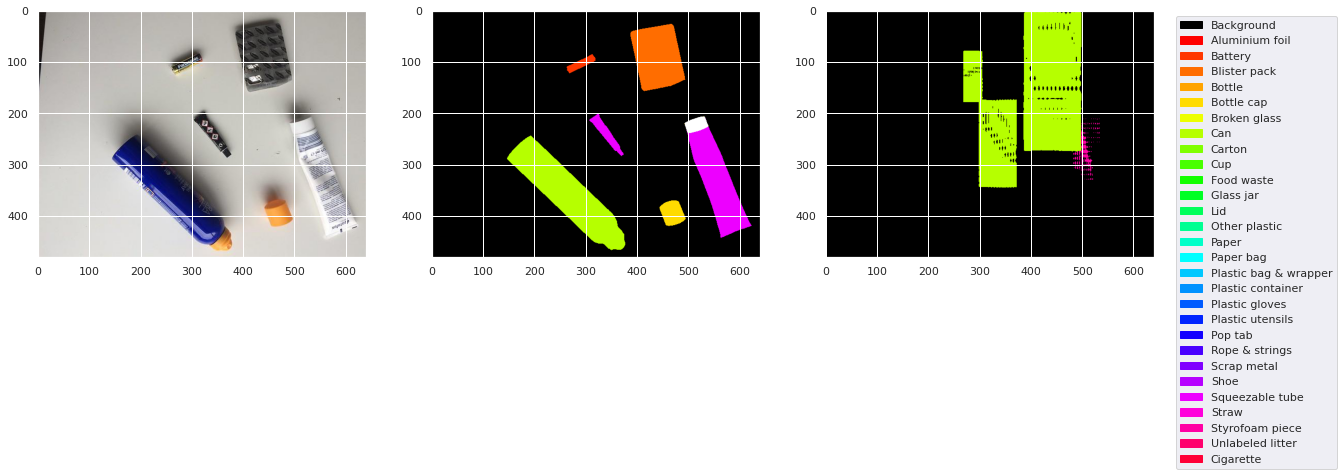

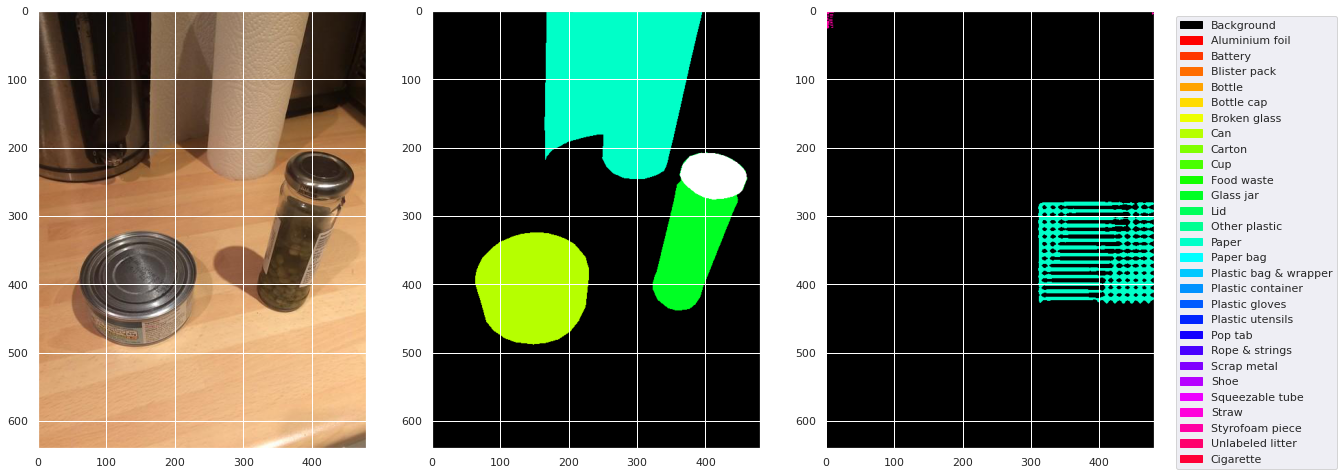

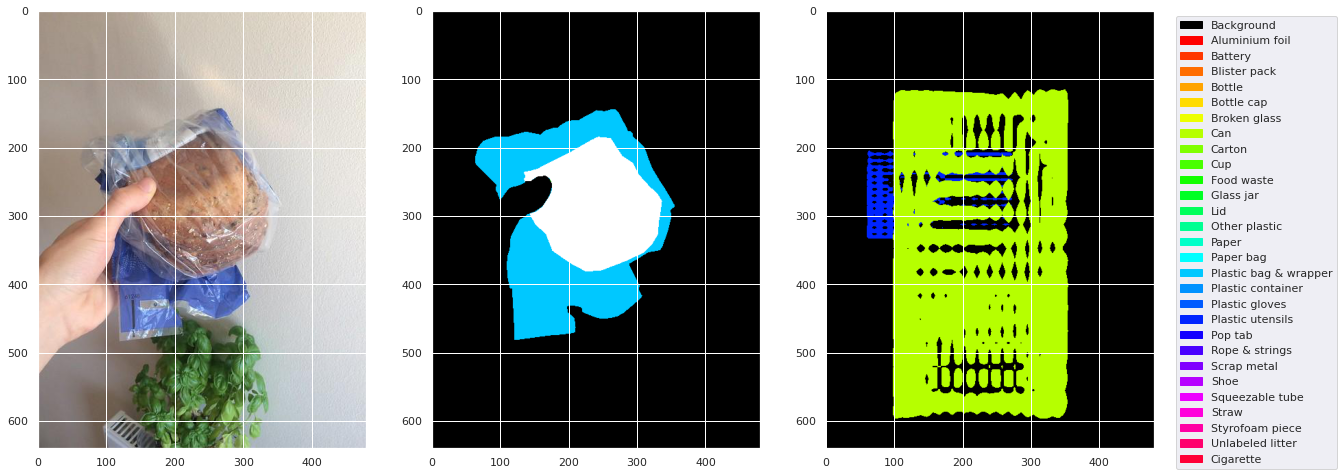

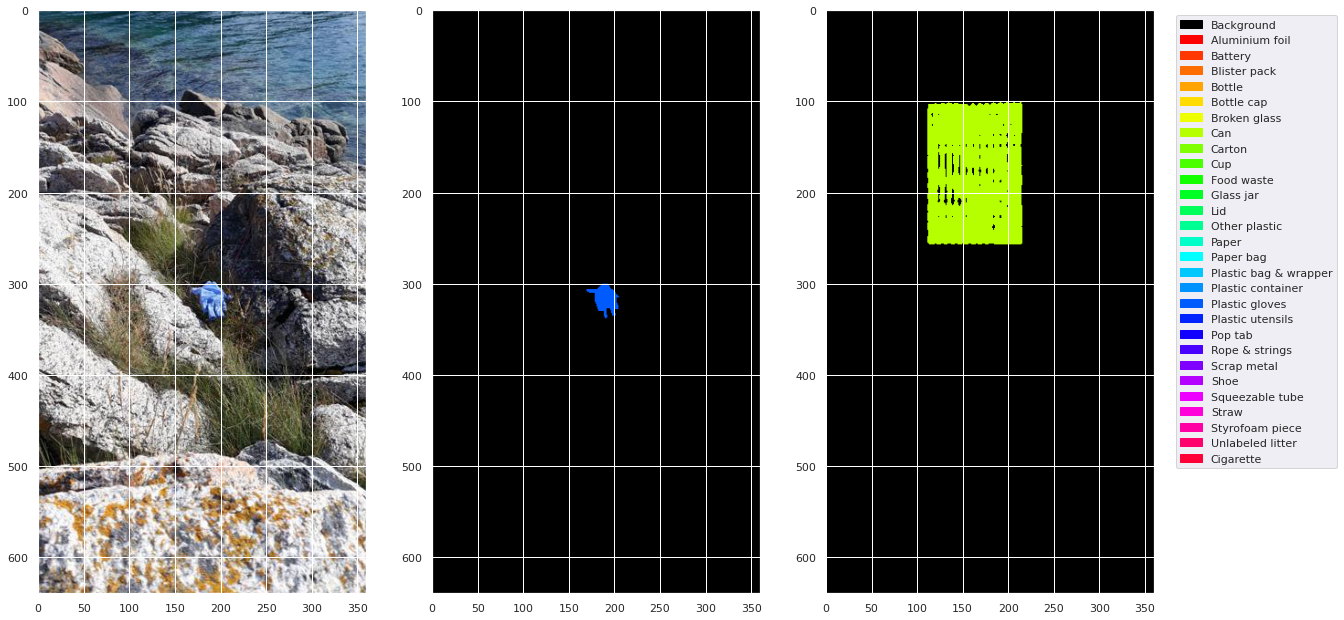

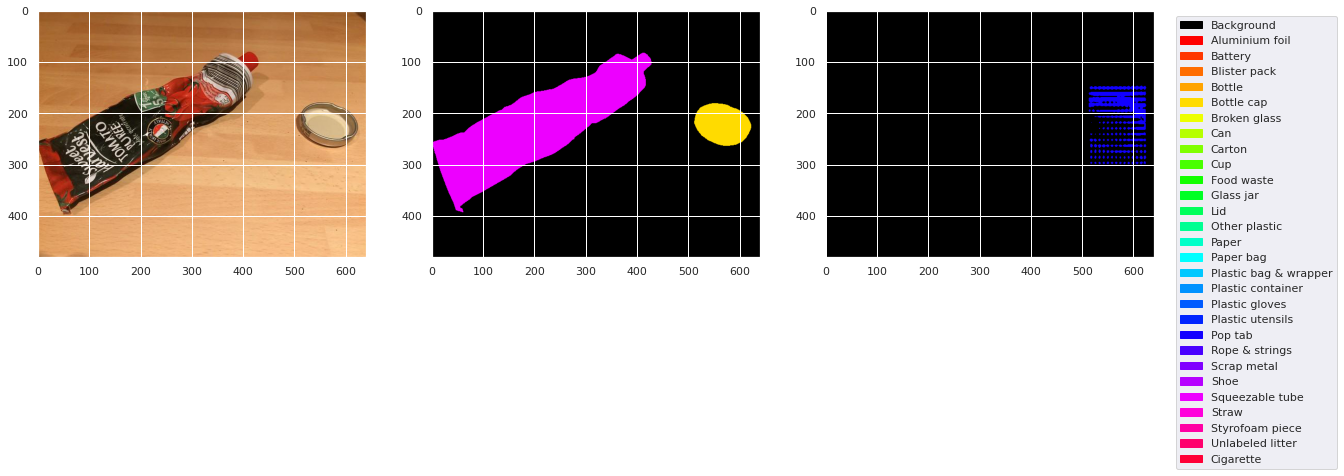

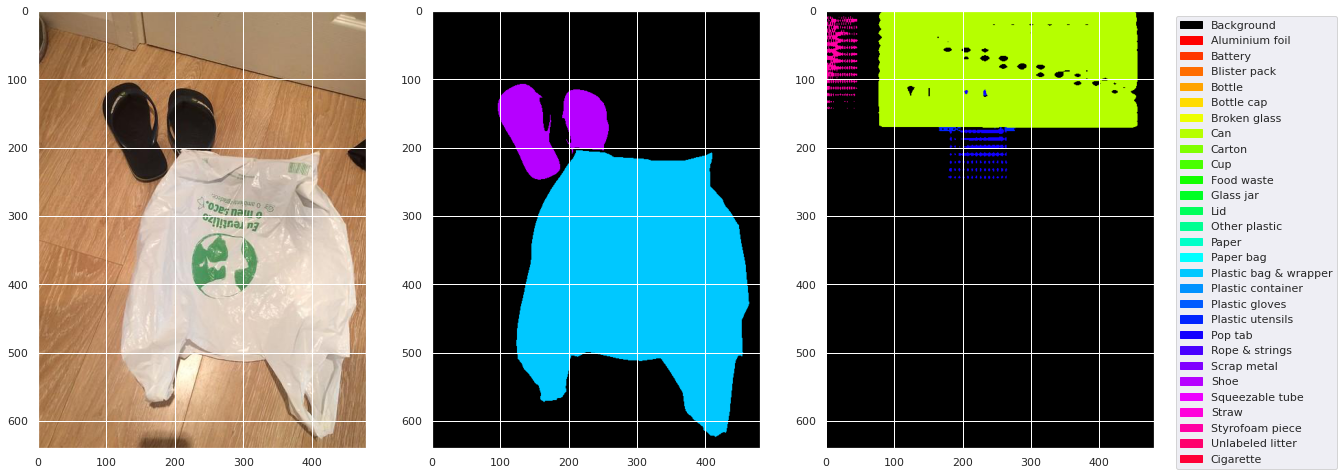

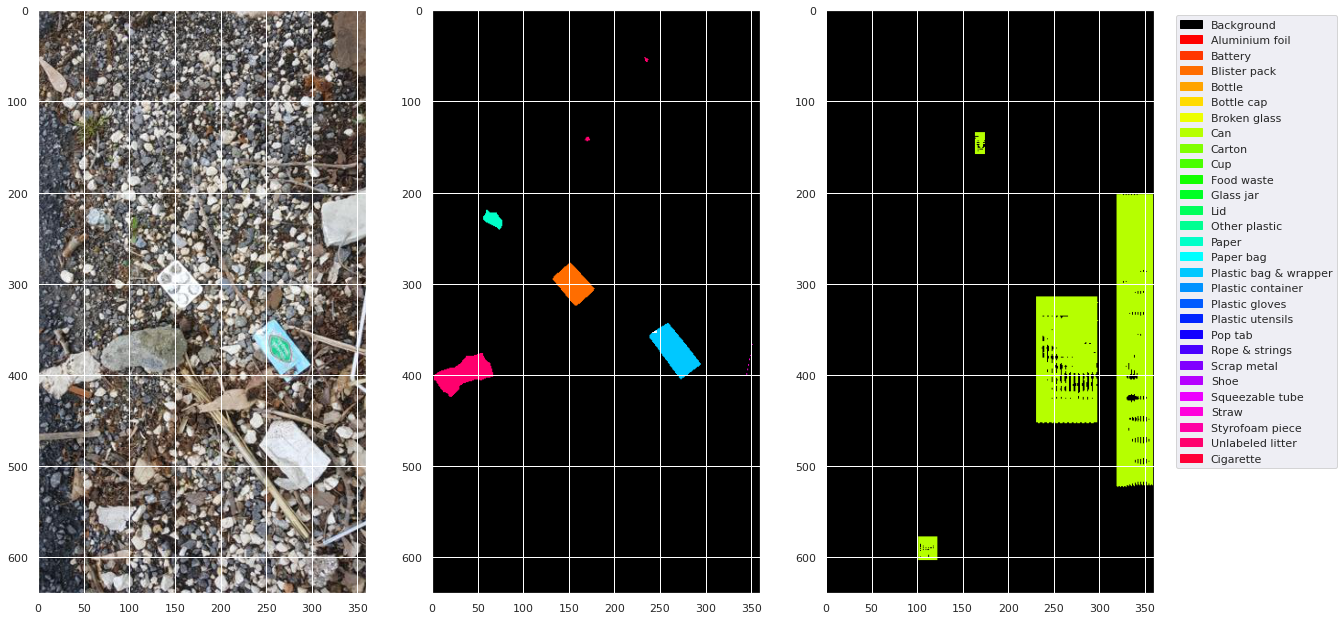

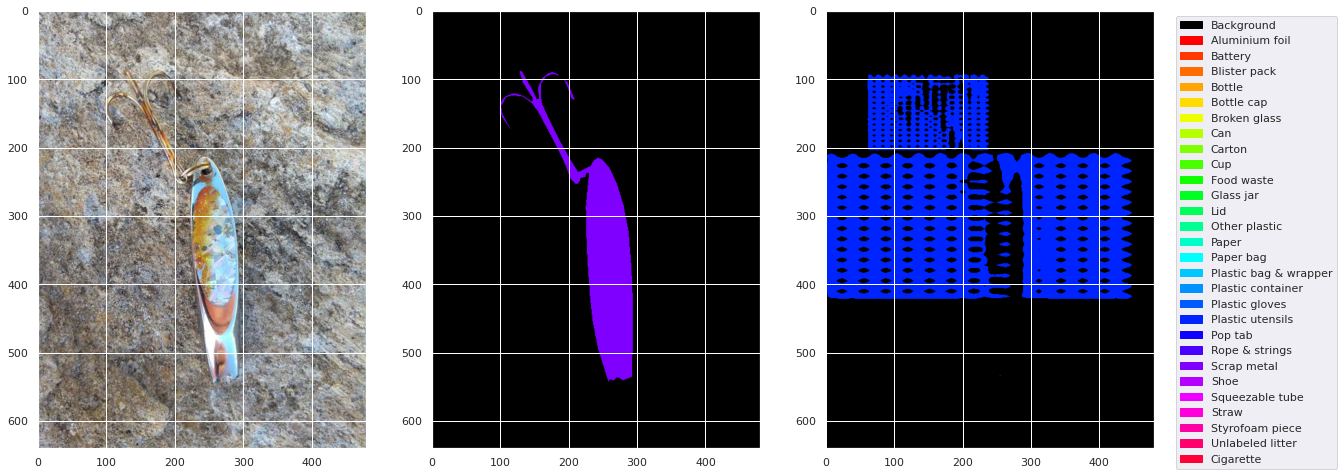

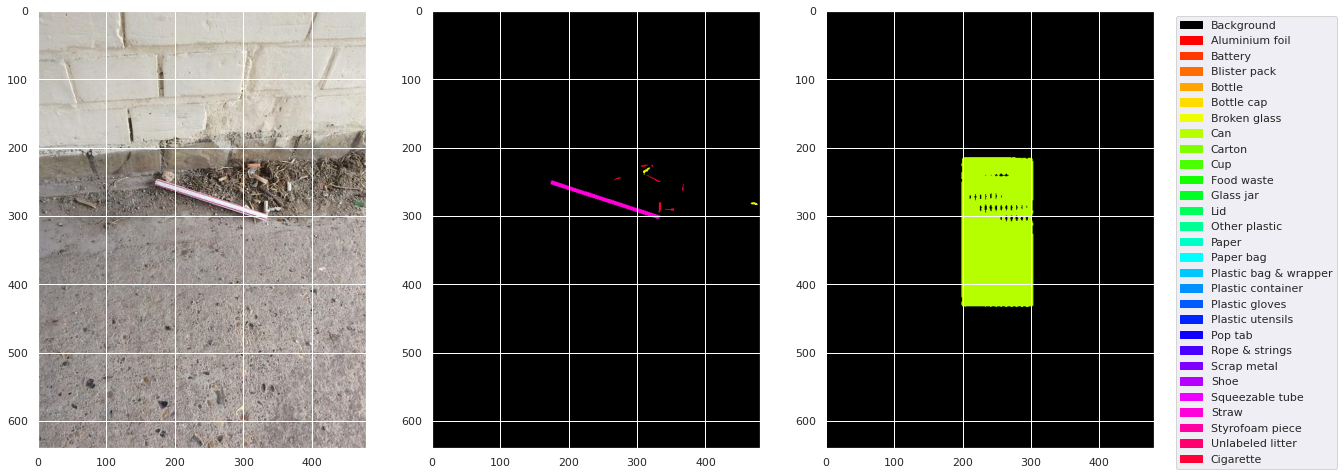

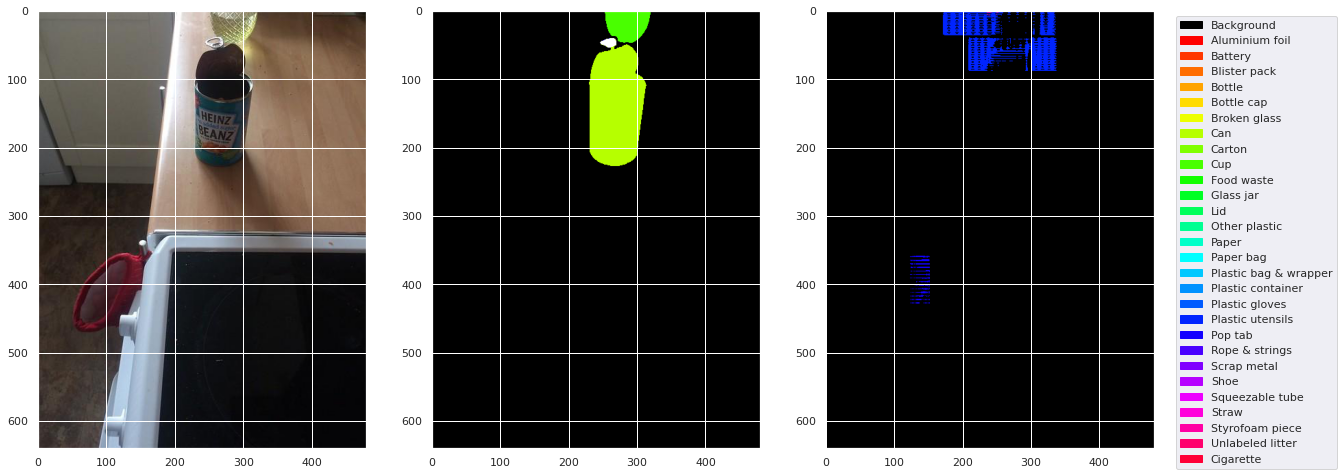

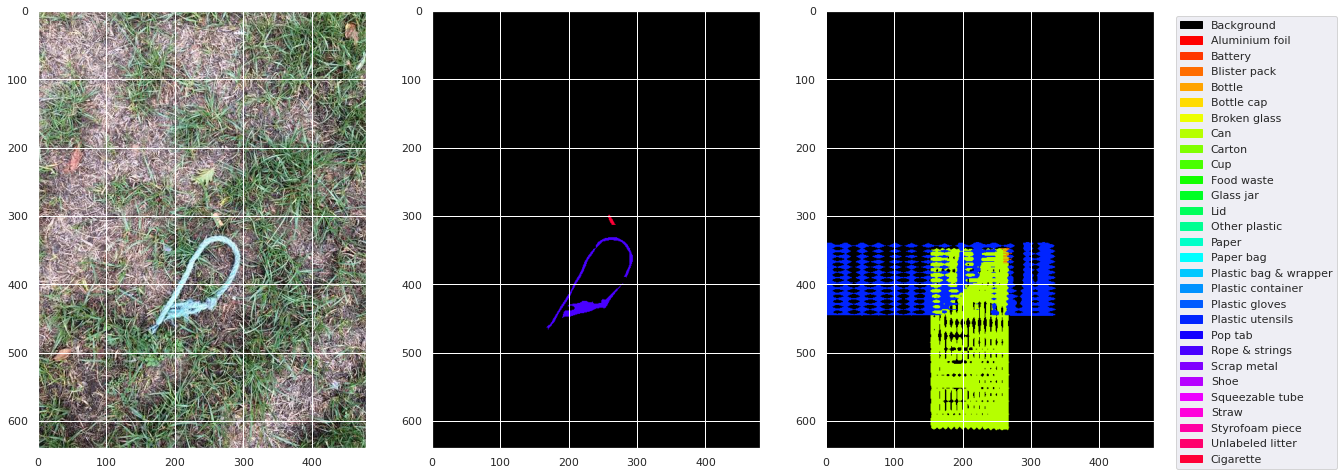

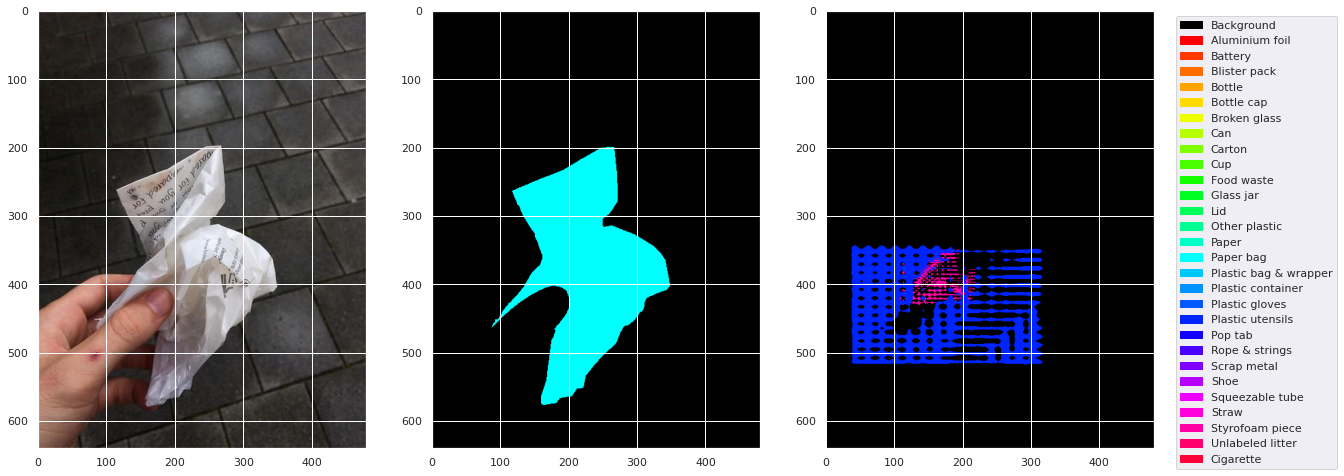

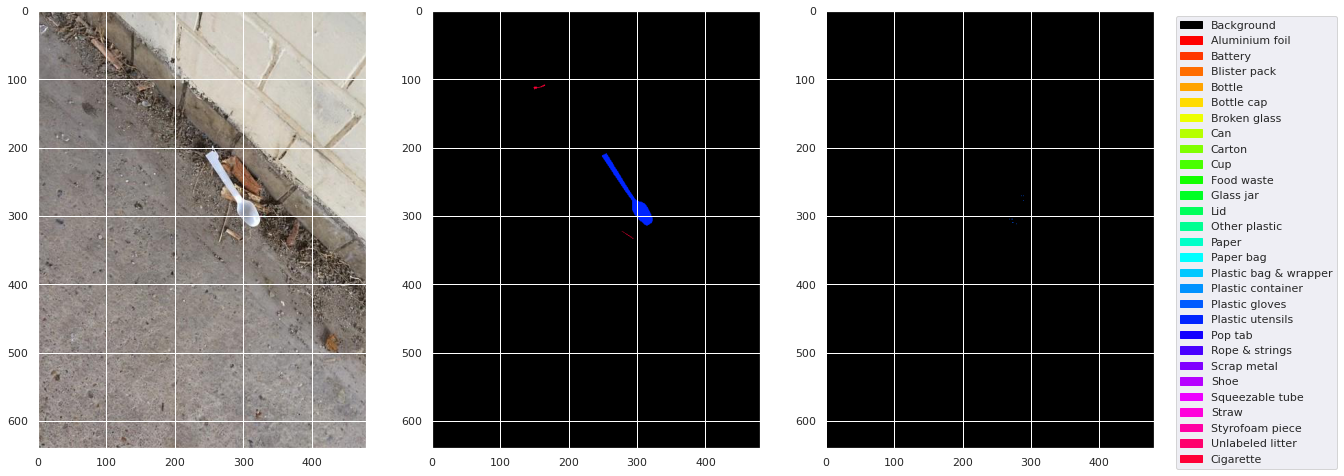

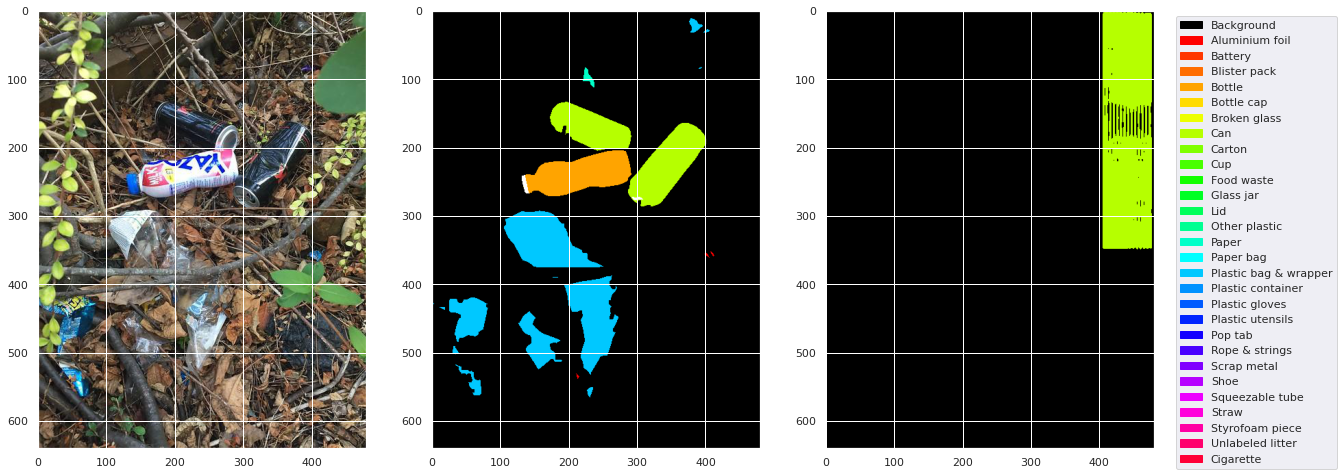

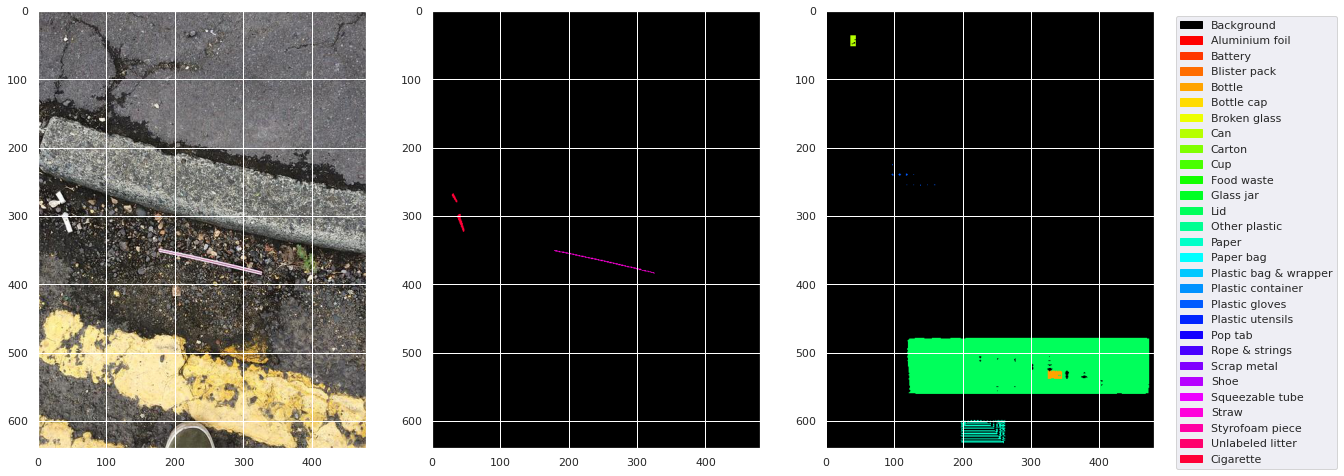

Error in callback <function flush_figures at 0x7f0ce51a32f0> (for post_execute):


KeyboardInterrupt: ignored

In [32]:
plot_mask_for_each_class(model_pretrained, one_image_per_class_list, ds, th=0.15)

### 30 epochs, no data augmentation

In [33]:
if False:
  model_30_epochs, losses_30_epochs = train_mask_rcnn(train_loader, val_loader, epochs=30, save_checkpoint=True, output_dir='/content/gdrive/My Drive',model_save_name="maskrcnn_30", checkpoint_path='/content/gdrive/My Drive/checkpoint_23.pth', save_losses="losses.txt")

In [34]:
thirty_epoch_loss = pd.read_csv('/content/gdrive/My Drive/losses_30_epochs.txt')

In [35]:
model_30_epochs = get_mask_rcnn_model()
model_30_epochs.load_state_dict(torch.load('/content/gdrive/My Drive/taco_mask_rcnn_30.pt'))
model_30_epochs.to(DEVICE)
model_30_epochs.eval()
engine.evaluate(model_30_epochs, test_loader, DEVICE)

KeyboardInterrupt: ignored

In [ ]:
plot_mask_for_each_class(model_30_epochs, one_image_per_class_list, ds, th=0.15)

### Aug


In [ ]:
model_30_epochs_taco_aug = get_mask_rcnn_model()
train_mask_rcnn(train_loader_aug, val_loader_aug, model_save_name="augmodel.pt", save_loss_name="auglosses.txt", save_checkpoint=True, output_dir='/content/gdrive/My Drive', checkpoint_path='/content/gdrive/My Drive/augmodel.pt_checkpoint_8.pth')

/usr/local/lib/python3.6/dist-packages/torch/autograd/anomaly_mode.py:70: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  warnings.warn('Anomaly Detection has been enabled. '
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Epoch: [9]  [  0/515]  eta: 0:17:13  lr: 0.000000  loss: 1.1513 (1.1513)  loss_classifier: 0.1951 (0.1951)  loss_box_reg: 0.1210 (0.1210)  loss_mask: 0.2720 (0.2720)  loss_objectness: 0.2503 (0.2503)  loss_rpn_box_reg: 0.3130 (0.3130)  time: 2.0069  data: 0.2192  max mem: 2996
Epoch: [9]  [ 10/515]  eta: 0:17:09  lr: 0.000000  loss: 0.8922 (0.8260)  loss_classifier: 0.1951 (0.1830)  loss_box_reg: 0.1045 (0.1021)  loss_mask: 0.3124 (0.3725)  loss_objectness: 0.0915 (0.0886)  loss_rpn_box_reg: 0.0373 (0.0798)  time: 2.0395  data: 0.2179  max mem: 3780
Epoch: [9]  [ 20/515]  eta: 0:16:39  lr: 0.000000  loss: 0.7159 (0.7547)  loss_classifier: 0.1629 (0.1738)  loss_box_reg: 0.0930 (0.0931)  loss_mask: 0.3151 (0.3687)  loss_objectness: 0.0369 (0.0655)  loss_rpn_box_reg: 0.0167 (0.0537)  time: 2.0198  data: 0.1936  max mem: 3780
Epoch: [9]  [ 30/515]  eta: 0:16:15  lr: 0.000000  loss: 0.7159 (0.7819)  loss_classifier: 0.1625 (0.1753)  loss_box_reg: 0.0773 (0.0909)  loss_mask: 0.3151 (0.3694) 

In [ ]:
model_aug = get_mask_rcnn_model()
model_aug.load_state_dict(torch.load('/content/gdrive/My Drive/taco_mask_rcnn_30_aug.pt'))
model_aug.to(DEVICE)
model_aug.eval()
engine.evaluate(model_aug, test_loader, DEVICE)